# MLFlow process for training using several different models

Potential use of following cell for collab purpose (decomment if needed)

In [ ]:
# !git clone https://github.com/tschuppr/ML_OPS.git
# %cd ML_OPS
# %pip install -r requirements.txt

## Imports

In [3]:
import mlflow
from mlflow.models import infer_signature
from mlflow.data.pandas_dataset import PandasDataset
from mlflow import MlflowClient

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os

Get the path to the general directory name

In [ ]:
gen_dirname = os.path.dirname(os.path.abspath(''))
# gen_dirname = os.path.abspath('') # In case use on collab switch comment

## Load the dataset

Two datasets are available :
- One gentle that has more features in it and better processed
- One rough with less features

The idea is to be able to compare the results of a learning process on both.

In [ ]:
type_of_dataset = "gentle"
source_dataset = os.path.join(gen_dirname,f"data\{type_of_dataset}\labelled.csv")

labeled_data = pd.read_csv(source_dataset)

labels = labeled_data["Survived"]
inputs = labeled_data.drop("Survived",axis="columns")

X_train, X_test, y_train, y_test = train_test_split(inputs,labels,test_size=0.3,random_state=42) # We are fixing the split so every run is comparable 

## Models

We are gonna evaluate some several models, feel free to add one and test it following what is done bellow.

We will logs informations about our models thanks to autologging for ease of use ans sake of simplicity, here is an image from MLFlow website to show what it does when launching an MLFlow run :

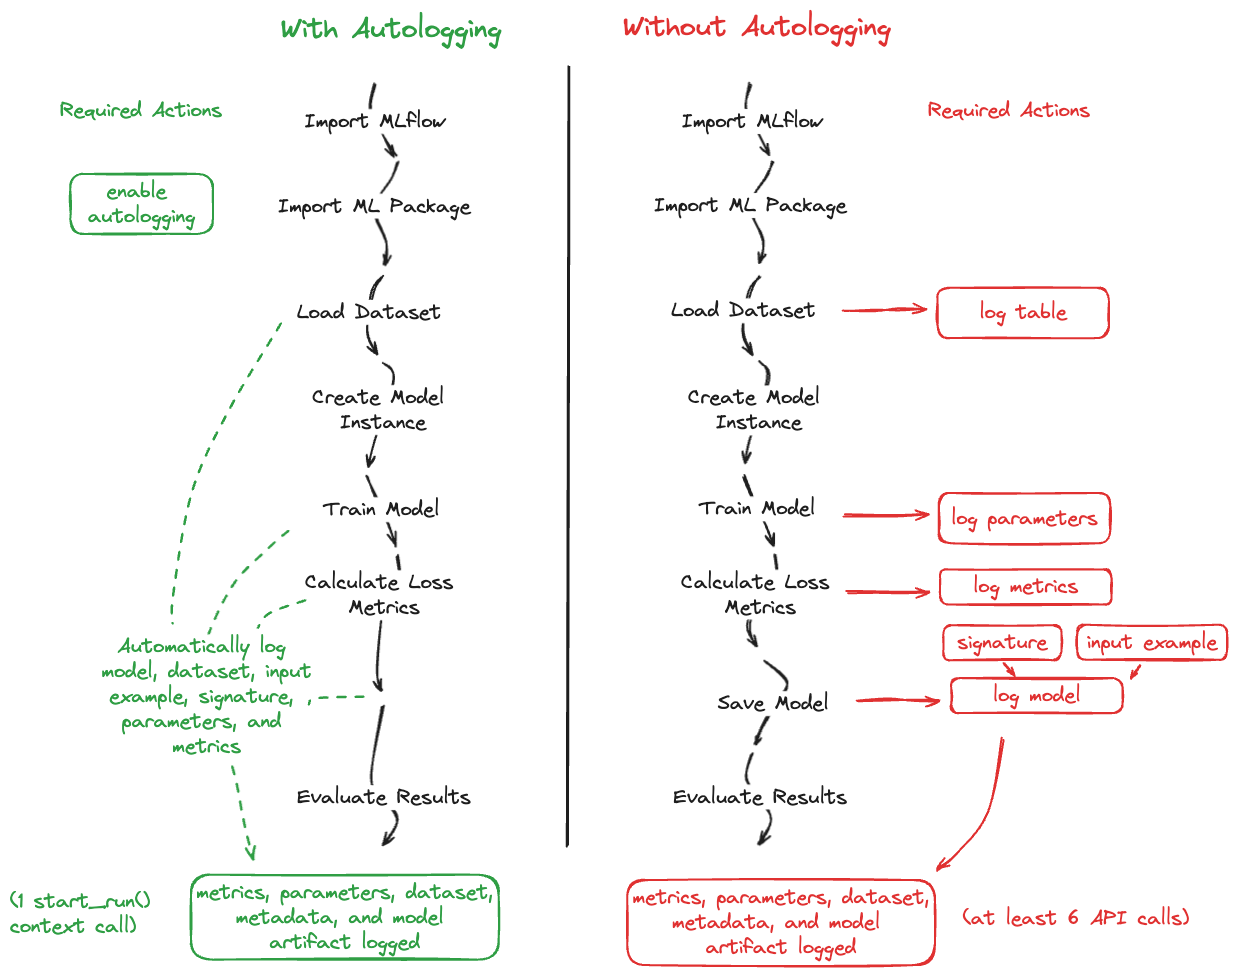 

In [ ]:
list_models = []

### LogisticRegression

In [ ]:
# Define the model hyperparameters
params_lr = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

# Create model instance
lr = LogisticRegression(**params_lr)

# Register in list 
list_models.append(["LogisticRegression",params_lr,lr,mlflow.sklearn.autolog])#,model_info])

### XGBoost

In [ ]:
# Define the model hyperparameters
params_xgb = {
    "n_estimators":20,
    "max_depth":100,
    "learning_rate": 0.3,
    "objective": "binary:logistic",
}

# Create model instance
bst = XGBClassifier(**params_xgb)

# Register in list 
list_models.append(["XGBoost",params_xgb,bst,mlflow.xgboost.autolog])#,model_info])

## Evaluation metrics

We are gonna set our metrics that will help compare our different models, because it is a classification task we are gonna focus on accuracy, recall, precision and confusion matrix.

In [ ]:
def eval_metrics(actual, preds):
    # Calculate metrics

    # Accuracy
    accuracy = accuracy_score(actual, preds)

    # recall
    recall = recall_score(actual, preds)

    # precision
    precision = precision_score(actual, preds)

    # Confusion matrix
    cnf_matr = confusion_matrix(actual,preds)
    cnf_matr_nm = cnf_matr.astype('float') / cnf_matr.sum(axis=1)[:, np.newaxis]

    return accuracy, recall, precision, cnf_matr_nm

## MLFlow part

More code in case this is used on collab

In [ ]:
# # run tracking UI in the background
# get_ipython().system_raw("mlflow ui &")

# from google.colab import output
# output.serve_kernel_port_as_window(5000)

An mlflow server need to be launched just before by using this command in your shell:
```sh
mlflow ui
```

We will start a different run for every different model that would be trained so the runs are well separated and MLFlow can understand the differences between each one them.

In [ ]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000") # take care of having the same adress as the one gave when you launched the server

# Create a new MLflow Experiment
mlflow.set_experiment("Titanic MLFlow demo")


for name,params,model,log_model in list_models:

    # Start an MLflow run
    with mlflow.start_run():
        
        log_model()

        # Log the hyperparameters
        mlflow.log_params(params)

        # Fit the model on training data
        model.fit(X_train, y_train)

        log_model(disable=True)
        # Final evaluation on the training sample
        preds_train = model.predict(X_train)

        # Log the train metric
        accuracy_train, recall_train, precision_train, cnf_matr_train = eval_metrics(y_train,preds_train)
        mlflow.log_metric("accuracy_train", accuracy_train)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("precision_train", precision_train)

        fig, ax = plt.subplots()

        sns.heatmap(cnf_matr_train, annot=True)
        ax.set_title("Normalized confusion Matrix Train Set", fontsize=14)
        plt.xlabel('Predicted Label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.close(fig)

        mlflow.log_figure(fig, "normalized_confusion_matrix_train.png")
        
        log_model(disable=False)
        # Make some prediction on the test set
        preds_test = model.predict(X_test)

        # Log the tests metric
        accuracy_test, recall_test, precision_test, cnf_matr_test = eval_metrics(y_test,preds_test)
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("precision_test", precision_test)
        fig, ax = plt.subplots()

        sns.heatmap(cnf_matr_test, annot=True)
        ax.set_title("Normalized confusion Matrix Test Set", fontsize=14)
        plt.xlabel('Predicted Label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.close(fig)

        mlflow.log_figure(fig, "normalized_confusion_matrix_test.png")

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", f"{name} model training for {type_of_dataset} titanic dataset")

        # Every run is tagged with 
        mlflow.set_tag("mlflow.runName", f"{name}")

## Inference with the chosen model

We are going to use the model component of mlflow to load and instantiate a model thanks to its unified api. 
Once loaded the model can be used for inference.

### Loading the model

In [ ]:
model_name = "XGBoost" # To be determined
model_version = "1" # Also to be determined

# Load saved model and make predictions
model_uri = f"models:/{model_name}/{model_version}"
loaded_model = mlflow.pyfunc.load_model(model_uri)

### Your survival test

In [ ]:
pclass = 3
sex = 0 # Reminder 0 for Male 1 for Female
age = 10
sibsp = 2
parch = 2
fare = 25.5467

one_person_data = pd.DataFrame([[pclass,sex,float(age),sibsp,parch,fare]],columns=["Pclass","Sex","Age","SibSp","Parch","Fare"])
predict_one_person = loaded_model.predict(one_person_data)

if predict_one_person == 0:
    print("You died")
else:
    print("Still standing")

### Testing inference on the whole dataset that was unlabelled  

In [ ]:
inference_dataset = os.path.join(gen_dirname,f"data\\{type_of_dataset}\\unlabelled.csv")

unllabeled_data = pd.read_csv(inference_dataset)
predictions = loaded_model.predict(unllabeled_data)

In [ ]:
predicted_data = unllabeled_data
predicted_data["Survived"] = predictions
print(predicted_data)

In [9]:
registry_uri = 
client = MlflowClient()
print(client.get_registered_model("tracking-quickstart"))
# Delete a registered model along with all its versions
client.delete_registered_model(name="tracking-quickstart")

MlflowException: Registered Model with name=tracking-quickstart not found